## Downloading the dataset

First of all, let's download the dataset. Dataset which we are going to analyze is a kaggle dataset called "Skin Cancer MNIST" which contains 10015 dermatoscopic images of all important diagnostic categories of pigmented skin lesions:  Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc). In order to download the dataset, we use Kaggle API. Please check [here](https://github.com/Kaggle/kaggle-api) for more information regarding how to install and use the API.

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
! touch ~/.kaggle/kaggle.json
! echo "paste content's of your kaggle.json file here" > ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
!kaggle datasets list -s cancer

ref                                             title                                           size  lastUpdated          downloadCount  
----------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
uciml/breast-cancer-wisconsin-data              Breast Cancer Wisconsin (Diagnostic) Data Set   48KB  2016-09-25 10:49:04          44539  
yuqing01/breast-cancer                          breast cancer                                   48KB  2017-10-23 11:21:30            962  
kmader/skin-cancer-mnist-ham10000               Skin Cancer MNIST: HAM10000                      3GB  2018-09-20 20:36:13           8564  
loveall/cervical-cancer-risk-classification     Cervical Cancer Risk Classification              8KB  2017-08-31 01:02:22           7919  
kmader/mias-mammography                         MIAS Mammography                               205MB  2017-11-01 10:50:49           1592  
piotrgrabo/breastcancerprot

In [8]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p data/

 99%|█████████████████████████████████████▊| 2.60G/2.62G [00:33<00:00, 68.3MB/s]
100%|██████████████████████████████████████| 2.62G/2.62G [00:33<00:00, 83.3MB/s]


After downloading the dataset, we unzip that into the data folder.

In [11]:
!unzip data/skin-cancer-mnist-ham10000.zip -d data/

Archive:  data/skin-cancer-mnist-ham10000.zip
  inflating: data/hmnist_28_28_RGB.csv  
  inflating: data/HAM10000_metadata.csv  
  inflating: data/HAM10000_images_part_1.zip  
  inflating: data/hmnist_28_28_L.csv  
  inflating: data/hmnist_8_8_L.csv   
  inflating: data/HAM10000_images_part_2.zip  
  inflating: data/hmnist_8_8_RGB.csv  


In [ ]:
!sudo unzip data/HAM10000_images_part_1.zip -d data/
!sudo unzip data/HAM10000_images_part_2.zip -d data/
! chmod 600 data/HAM10000_metadata.csv

## Setup and data preparation

In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore')

First we put dataset''s metadata into a pandas dataframe. This dataframe later we be used in order to create a databunch from images.  

In [2]:
df = pd.read_csv("data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Next we map dx column to lesion types:

In [3]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['lesion'] = df.dx.map(lesion_type_dict)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


Here we examine the number of images in each of the seven categories of skin lesions.
It is clear that this dataset is imbalanced, with 6705 samples in 'Melanocyctic nevi' class and only 115 'Dermatofibroma' samples.

In [4]:
print(df.lesion.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


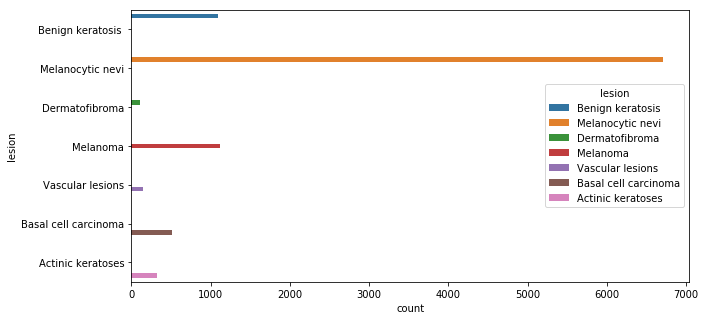

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In order to alleviate the class imabalance issue, we apply random undersampling to classes with over 200 samples:

## Undersampling

In [6]:
num_sample = 200

df_df = df.loc[df['dx'] == "df"][0:115]
df_vasc = df.loc[df['dx'] == "vasc"][0:142]
df_akiec = (df.loc[df['dx'] == "akiec"]).sample(num_sample)
df_bcc = df.loc[df['dx'] == "bcc"][0:num_sample].sample(num_sample)
df_bkl = df.loc[df['dx'] == "bkl"][0:num_sample].sample(num_sample)
df_mel = df.loc[df['dx'] == "mel"][0:num_sample].sample(num_sample)
df_nv = df.loc[df['dx'] == "nv"][0:num_sample].sample(num_sample)

df = pd.concat([df_akiec, df_bcc, df_bkl, df_df, df_mel, df_nv, df_vasc])
df = shuffle(df)

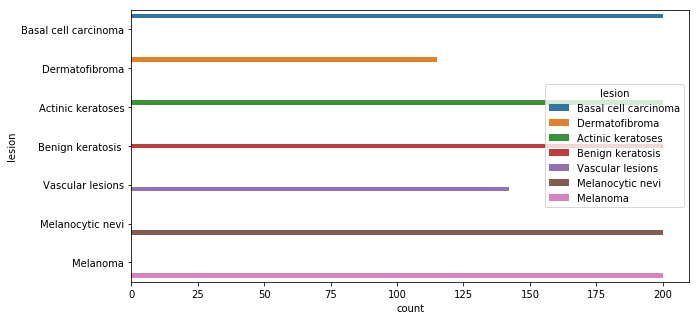

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

Next we create an ImageDataBunch object from sampled dataset and apply common data augmentations to this dataset. We also normalize this dataset using ImageNet stats.

## Loading the data

In [8]:
tfms = get_transforms(flip_vert=True)
data = ImageDataBunch.from_df("data/", df, fn_col=1, suffix='.jpg', label_col=7, ds_tfms=tfms, size=224, bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (1006 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Basal cell carcinoma,Dermatofibroma,Dermatofibroma,Benign keratosis ,Actinic keratoses
Path: data;

Valid: LabelList (251 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Benign keratosis ,Basal cell carcinoma,Dermatofibroma,Actinic keratoses,Actinic keratoses
Path: data;

Test: None

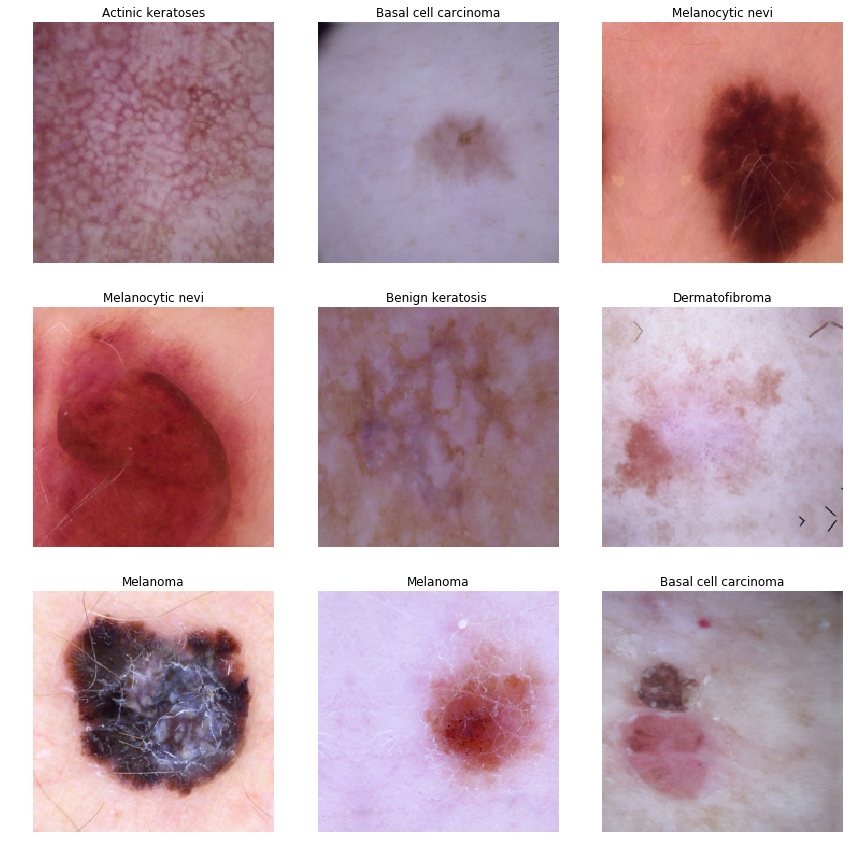

In [16]:
data.show_batch(rows=3)

## Model training and evaluation

Now we create a Learner object using a freezed pretrained densenet169 architecture:

In [9]:
learner = cnn_learner(data, models.densenet169, metrics=[accuracy, FBeta(average='macro')], model_dir="../models/")
learner.loss_func = nn.CrossEntropyLoss()

Before starting the training process, let's find the optimum learning rate using learning rate finder.
The plot shows that the steepest decrease in the loss value happens when learning rate is around 1e-03 value.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


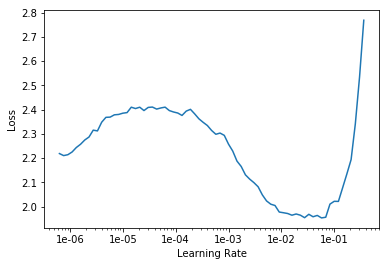

In [12]:
learner.lr_find()
learner.recorder.plot()

Now we train the model using the optimum learning rate. We also save the best model according to the accuracy of each epoch. Later we use this file to productionize our classifier:

In [10]:
learner.fit_one_cycle(30, 1e-3, callbacks=[SaveModelCallback(learner, every='improvement', monitor='accuracy', name='model_best')])

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.085684,1.654159,0.350598,0.340776,00:39
1,1.723471,1.072841,0.609562,0.562534,00:27
2,1.357395,0.835954,0.709163,0.683892,00:26
3,1.075796,0.664414,0.749004,0.726332,00:27
4,0.878755,0.620203,0.788845,0.787139,00:27
5,0.773527,0.565302,0.776892,0.780800,00:27
6,0.662125,0.582520,0.788845,0.783491,00:26
7,0.593850,0.550581,0.816733,0.824112,00:27
8,0.532479,0.537552,0.824701,0.820410,00:27
9,0.483688,0.431171,0.844622,0.841533,00:27


Better model found at epoch 0 with accuracy value: 0.350597620010376.
Better model found at epoch 1 with accuracy value: 0.6095617413520813.
Better model found at epoch 2 with accuracy value: 0.7091633677482605.
Better model found at epoch 3 with accuracy value: 0.7490040063858032.
Better model found at epoch 4 with accuracy value: 0.788844645023346.
Better model found at epoch 7 with accuracy value: 0.8167330622673035.
Better model found at epoch 8 with accuracy value: 0.824701189994812.
Better model found at epoch 9 with accuracy value: 0.8446215391159058.
Better model found at epoch 11 with accuracy value: 0.8645418286323547.
Better model found at epoch 14 with accuracy value: 0.8844621777534485.
Better model found at epoch 15 with accuracy value: 0.892430305480957.
Better model found at epoch 19 with accuracy value: 0.912350594997406.


As you can see, the best model found at epoxh 19 and the with accuracy of around %91.2 and f-measure of %91.7

## Model interpretation

In [33]:
learner = learner.load("model_best")

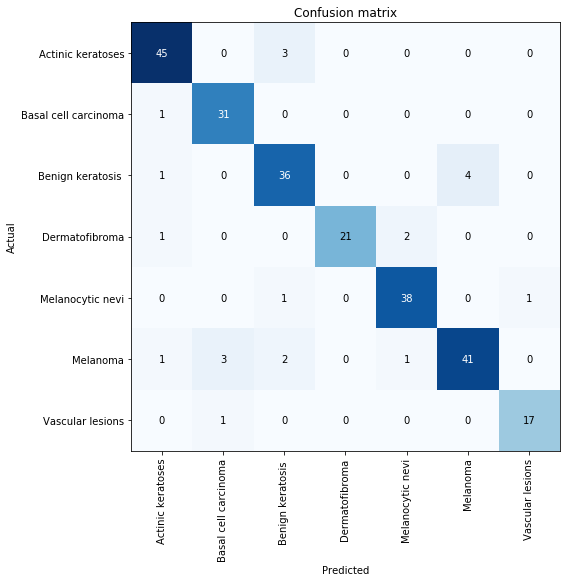

In [34]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [35]:
interp.most_confused()

[('Benign keratosis ', 'Melanoma', 4),
 ('Actinic keratoses', 'Benign keratosis ', 3),
 ('Melanoma', 'Basal cell carcinoma', 3),
 ('Dermatofibroma', 'Melanocytic nevi', 2),
 ('Melanoma', 'Benign keratosis ', 2),
 ('Basal cell carcinoma', 'Actinic keratoses', 1),
 ('Benign keratosis ', 'Actinic keratoses', 1),
 ('Dermatofibroma', 'Actinic keratoses', 1),
 ('Melanocytic nevi', 'Benign keratosis ', 1),
 ('Melanocytic nevi', 'Vascular lesions', 1),
 ('Melanoma', 'Actinic keratoses', 1),
 ('Melanoma', 'Melanocytic nevi', 1),
 ('Vascular lesions', 'Basal cell carcinoma', 1)]

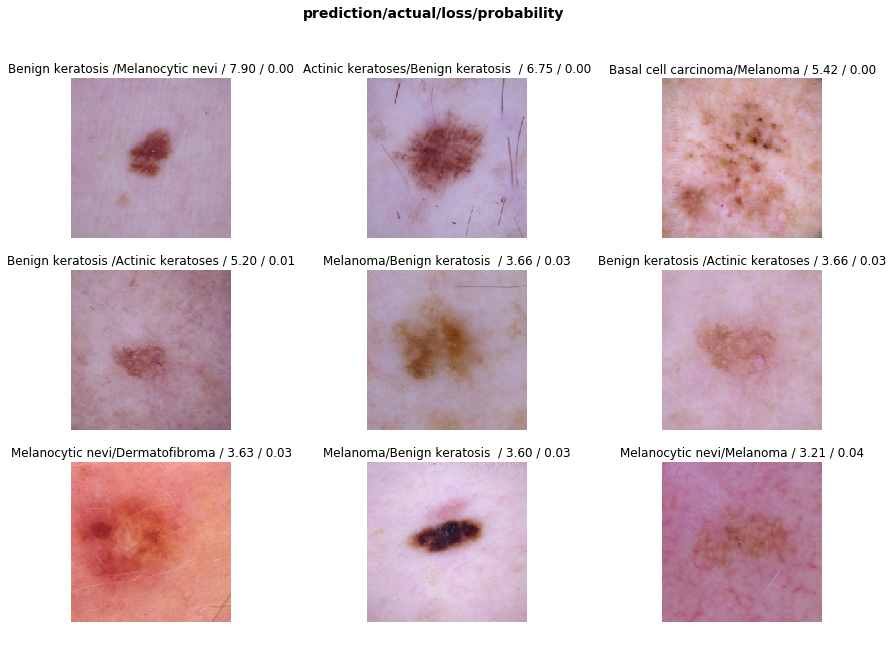

In [38]:
interp.plot_top_losses(9, figsize=(15,10), heatmap=False)